In [27]:
from model.deeponet import *
import numpy as np
from src.collision_operator_HG_1D import CollisionOperatorHG1D
from src.collision_operator_HG_3D import CollisionOperatorHG3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [28]:
gpu_id='3'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  3


## 1D case

In [29]:
dimension=1
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_64_3_64_HG_wo_bias',
    '3_64_3_64_HG_w_bias',
    '3_64_3_64_HG_soft_lamb01',
    '3_64_3_64_HG_hard_gram',
    '3_64_3_64_HG_hard_special'
]

In [30]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [60]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(0.9)+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(0.9)+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

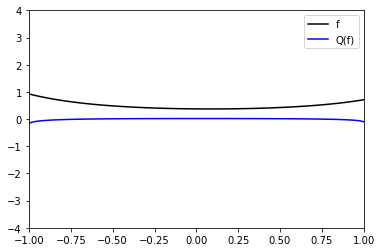

Volume is 1.0


In [65]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()
print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [17]:
train_data_f.shape

torch.Size([100, 100])

In [ ]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

10000
tensor(0.0419)
9800
tensor(0.0407)
9900
tensor(0.0958)
9900
tensor(0.0741)
9800
tensor(0.0116)


In [ ]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

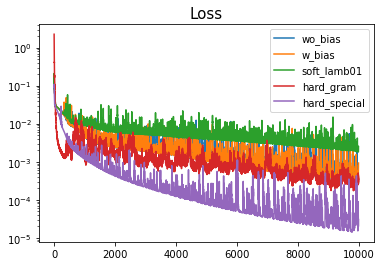

In [ ]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

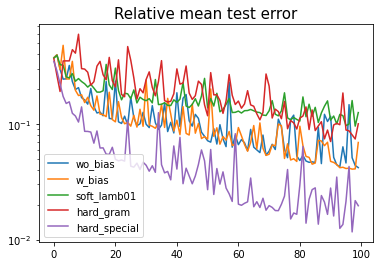

In [ ]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [ ]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

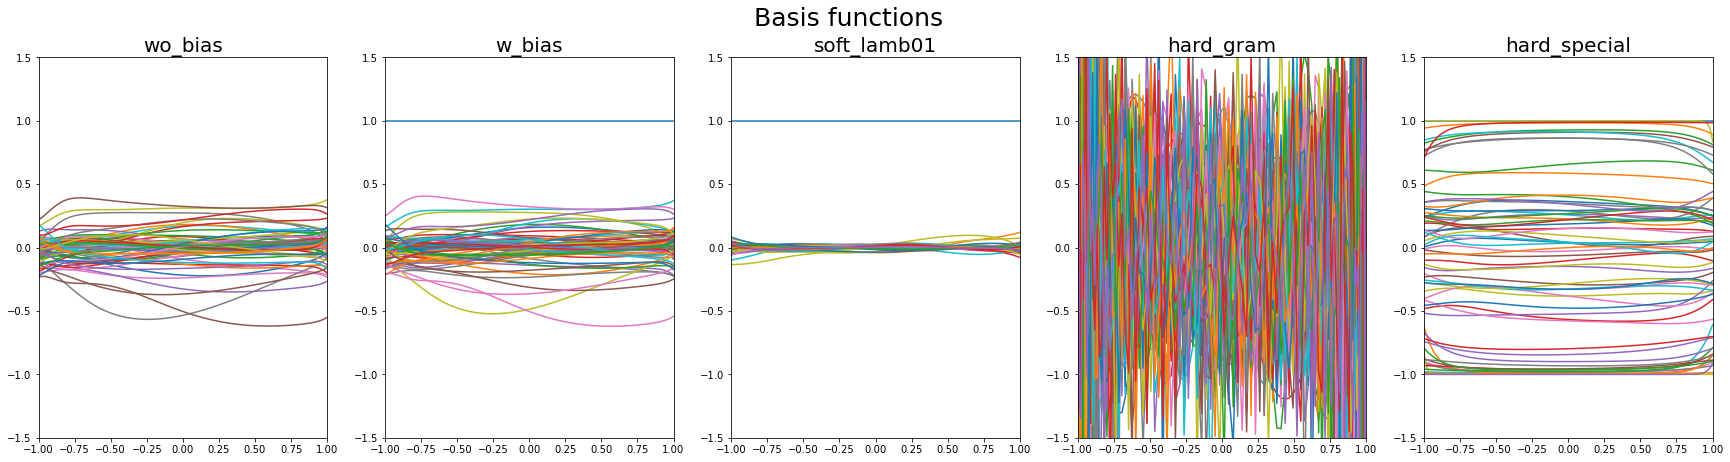

In [ ]:
plt.figure(figsize=(30,7))
plt.suptitle(r'Basis functions', fontsize=25)
for idx in range(len(models)):
    ax=plt.subplot(1,len(models),idx+1)
    ax.set_title(names[idx], fontsize=20)
    for i in range(n_basiss[idx]):
        ax.plot(grid.detach().cpu(),all_basis[idx][i], label='{}-th basis'.format(i))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1.5,1.5)
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.show()

In [ ]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

Mean_test error of total test data for wo_bias     =4.19E-02
Mean_test error of total test data for w_bias      =4.07E-02
Mean_test error of total test data for soft_lamb01 =9.58E-02
Mean_test error of total test data for hard_gram   =7.41E-02
Mean_test error of total test data for hard_special=1.16E-02


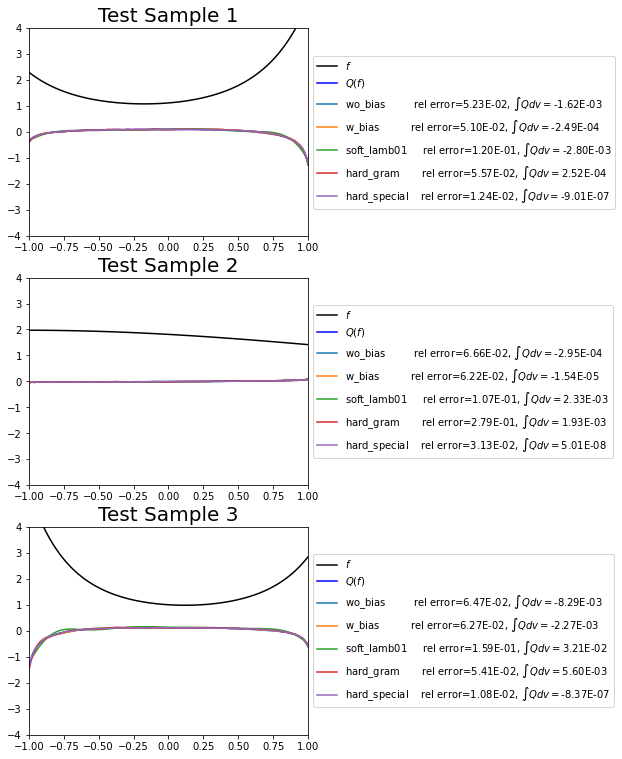

In [ ]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    ax.set_title("Test Sample {}".format(str(plot_idx+1)), fontsize=20)
    data_idx=np.random.randint(test_data_f.shape[0])
    
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        models[idx]
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.2E}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
            print("Mean_test error of total test data for {:12s}={:.2E}".format(names[idx], rel_L2_error(prediction_all, test_data_Q).mean()))
#         print(names[idx])
#         print("Rel error : {:.3f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
#         print(r'$\int Q dv=${:.5f}'.format(torch.sum(prediction*quad_w.detach().cpu())))
#         print(" ")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

## 3D case

In [66]:
dimension=3
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_64_3_64_HG_wo_bias',
    '3_64_3_64_HG_w_bias',
    '3_64_3_64_HG_soft_lamb01',
    '3_64_3_64_HG_hard_gram',
    '3_64_3_64_HG_hard_special'
]

In [67]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [70]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(0.0)+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(0.0)+'_test_data.npz')


train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=8#gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

Volume is 1.0
Qdv is -3.725290298461914e-09


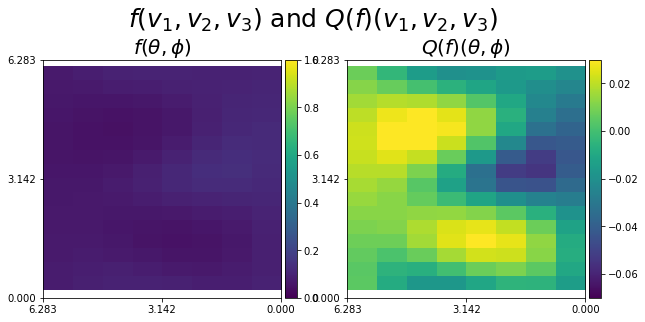

In [89]:
idx=np.random.randint(train_data_f.shape[0])

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig=plt.figure(figsize=(10,5))
plt.suptitle(r'$f(v_1,v_2,v_3)$ and $Q(f)(v_1,v_2,v_3)$', fontsize=25)
ax=plt.subplot(1,2,1)
ax.set_title(r'$f(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_f[idx].reshape(integration_order*2,integration_order), vmin=0, vmax=1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r'$Q(f)(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_Q[idx].reshape(integration_order*2,integration_order), vmin=-0.07, vmax=0.03, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))
print("Qdv is {}".format(torch.sum(train_data_Q[idx]*quad_w.detach().cpu()).item()))

In [ ]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

9100
tensor(0.1785)
8800
tensor(0.1870)
9700
tensor(0.2178)
6600
tensor(0.0592)
7100
tensor(0.1893)


## 3D case

In [3]:
dimension=3
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_64_3_64_HG_wo_bias',
    '3_64_3_64_HG_w_bias',
    '3_64_3_64_HG_soft_lamb01',
    '3_64_3_64_HG_hard_gram',
    '3_64_3_64_HG_hard_special'
]

In [4]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [5]:
### Data
## Load data
train_data=np.load('data/'+'legendre_train_data.npz')
test_data=np.load('data/'+'legendre_test_data.npz')


train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

In [8]:
train_data_Q.shape

torch.Size([100, 100])

RuntimeError: shape '[20, 10]' is invalid for input of size 100

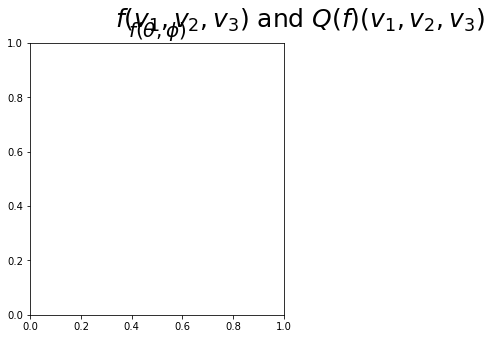

In [6]:
idx=np.random.randint(train_data_f.shape[0])

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig=plt.figure(figsize=(10,5))
plt.suptitle(r'$f(v_1,v_2,v_3)$ and $Q(f)(v_1,v_2,v_3)$', fontsize=25)
ax=plt.subplot(1,2,1)
ax.set_title(r'$f(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_f[idx].reshape(20,10), vmin=0, vmax=1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r'$Q(f)(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_Q[idx].reshape(20,10), vmin=-0.07, vmax=0.03, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [28]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

9100
tensor(0.1785)
8800
tensor(0.1870)
9700
tensor(0.2178)
6600
tensor(0.0592)
7100
tensor(0.1893)


In [29]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

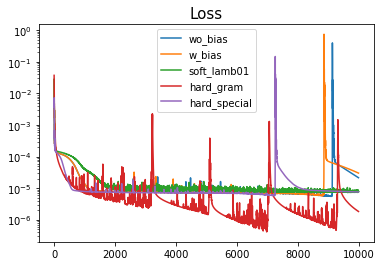

In [30]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

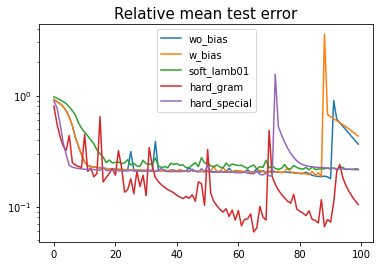

In [31]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [32]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

In [33]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

wo_bias     => (sample) test error=1.93E-01, Qdv=-9.31E-05 & (All) test error=1.79E-01
w_bias      => (sample) test error=2.04E-01, Qdv=4.62E-04 & (All) test error=1.87E-01
soft_lamb01 => (sample) test error=2.20E-01, Qdv=2.95E-03 & (All) test error=2.18E-01
hard_gram   => (sample) test error=8.11E-02, Qdv=2.03E-05 & (All) test error=5.92E-02
hard_special=> (sample) test error=2.02E-01, Qdv=9.57E-08 & (All) test error=1.89E-01


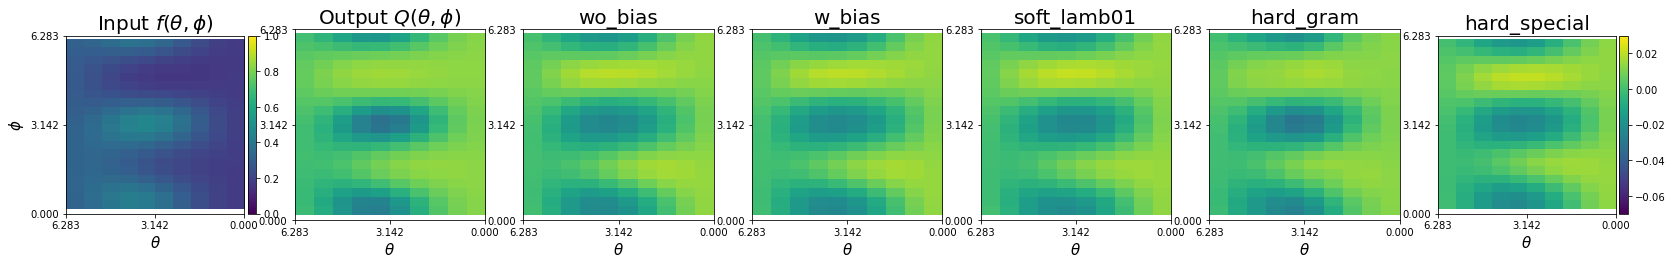

In [35]:
data_idx=np.random.randint(test_data_f.shape[0])

plt.figure(figsize=(28,5))

ax=plt.subplot(1,7,1)
ax.set_title(r"Input $f(\theta,\phi)$", fontsize=20)
im=ax.imshow(test_data_f[data_idx].reshape(20,10), vmin=0, vmax=1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_ylabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

ax=plt.subplot(1,7,2)
ax.set_title(r"Output $Q(\theta,\phi)$", fontsize=20)
im=ax.imshow(test_data_Q[data_idx].reshape(20,10), vmin=-0.07, vmax=0.03, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

for idx in range(len(models)):
    ax=plt.subplot(1,7,idx+2+1)
    prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
    ax.set_title("{}".format(names[idx]), fontsize=20)
    im=ax.imshow(prediction.reshape(20,10), vmin=-0.07, vmax=0.03, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
    ax.set_xlabel(r'$\theta$',fontsize=15)
    ax.set_xticks([0,np.pi,2*np.pi])
    ax.set_yticks([0,np.pi,2*np.pi])
    prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
    print("{:12s}=> (sample) test error={:.2E}, Qdv={:.2E} & (All) test error={:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu()), rel_L2_error(prediction_all, test_data_Q).mean()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()